In [2]:
%matplotlib inline

# SYDE 522 Assignment 4

## Deep Networks and Convolution

### Due: Nov 29, 2023

The purpose of this assignment is to train some deep networks to recognize images.  We will start with MNIST (the standard hand-written numbers dataset) and then go on to the harder CIFAR-10 (recognizing pictures in 10 categories).

All of these datasets are publically available, and for this assignment you should use the Python package `tensorflow` to implement and train the neural network.  On most python systems this can be installed with:

```
pip install tensorflow
```

For more information on installing, see https://www.tensorflow.org/install

For this assignment, you will not need to install the GPU version of `tensorflow`.  If you want to work with larger deep learning models and make things run faster (for your project, for example), then instructions for doing so are at https://www.tensorflow.org/install/gpu

This assignment sheet is a Jupyter Notebook file https://jupyter.org/ which you can use if you want as a starting point.

## Part 1: MNIST

First, we download the data files.  They are already split into a training set and a test set.

In [1]:
import tensorflow.keras.datasets.mnist as mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0   # rescale the images to be between 0 and 1
x_test = x_test / 255.0     # rescale the images to be between 0 and 1

Let's show the first 10 training images and their category labels.

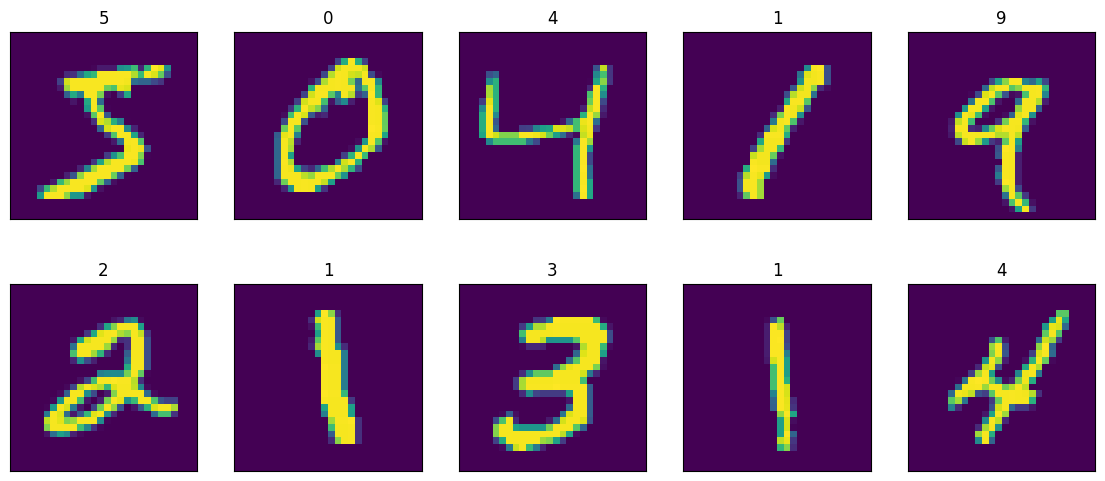

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.title('%d' % y_train[i])
plt.show()

The `y_train` and `y_target` values are currently integers (0 to 9).  The output from our network is a vector where one value should be 1 and the others should be 0 (one-hot encoding), so we need to convert to that format.  (Note: there is a special loss function `sparse_categorical_crossentropy` that automatically converts for us.  We'll use that later, but for now do this manually, just to keep things clear.)

In [3]:
import numpy as np

y_train_target = np.eye(10)[y_train]
y_test_target = np.eye(10)[y_test]
print('original target:', y_train[0])
print('  vector target:', y_train_target[0])

original target: 5
  vector target: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Now we define the model using Keras https://keras.io/, which is meant for being able to quickly define all the different structures you might want to add to your network. We use `Sequential` to indicate that this is just a big feed-forward network, and we define each layer in turn.  `Dense` is a layer where all the components are connected to all of the previous layer's outputs.

In [4]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
  tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
  tf.keras.layers.Dense(10, activation='relu')     # 10 outputs (one for each category)
])

# define what we want to minimize (the thing that we take the derivative of to get the weight changes)
def my_loss(y_true, y_predict):
    return (y_true-y_predict)**2

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), # use stochastic gradient descent
              loss=my_loss,
              metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
             )

Before doing any training, let's see how well it performs.

In [15]:
loss, accuracy = model.evaluate(x_test,  y_test_target)

313/313 [==============================] - 0s 421us/step - loss: 0.1334 - accuracy: 0.0607


As expected, it's pretty bad, since we haven't done any training yet.  The accuracy is near 10%, which is what we would expect by chance.  But what actual numbers is it outputting?

313/313 [==============================] - 0s 444us/step


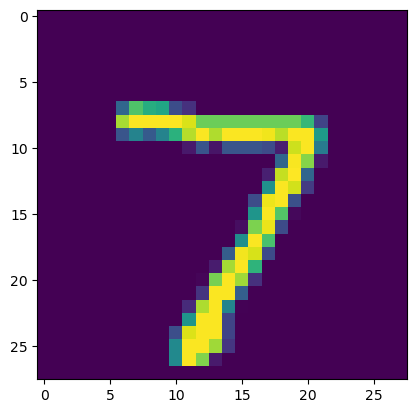

actual output from network: [0.23694628 0.         0.         0.26332176 0.         0.
 0.17939256 0.         0.         0.        ]
category (the largest output): 3


In [16]:
output = model.predict(x_test)
category = np.argmax(output, axis=1)

plt.imshow(x_test[0])
plt.show()
print('actual output from network:', output[0])
print('category (the largest output):', category[0])


So it currently thinks the first image in the test dataset is is a 6, when it should actually be a 7 (note: when you run this, you may get a different number, as each network starts out randomly different).  

Now let's try training the model.  We'll just do 5 epochs of training (5 times through all the training data).  While it is training, we also tell it to see how well the model is performing on the testing data (technically this is considered to be validation data, since we're looking at it while we are doing training.  Real testing data would only ever be used at the very end after all training has finished).

In [31]:
history = model.fit(x_train, y_train_target, epochs=5, validation_data=(x_test, y_test_target));
print(history.history)

Epoch 1/5
1875/1875 [==============================] - 1s 577us/step - loss: 0.0398 - accuracy: 0.7398 - val_loss: 0.0270 - val_accuracy: 0.8329
Epoch 2/5
1875/1875 [==============================] - 1s 535us/step - loss: 0.0264 - accuracy: 0.8385 - val_loss: 0.0243 - val_accuracy: 0.8486
Epoch 3/5
1875/1875 [==============================] - 1s 568us/step - loss: 0.0242 - accuracy: 0.8489 - val_loss: 0.0227 - val_accuracy: 0.8570
Epoch 4/5
1875/1875 [==============================] - 1s 533us/step - loss: 0.0228 - accuracy: 0.8555 - val_loss: 0.0217 - val_accuracy: 0.8621
Epoch 5/5
1875/1875 [==============================] - 1s 534us/step - loss: 0.0218 - accuracy: 0.8601 - val_loss: 0.0209 - val_accuracy: 0.8650
{'loss': [0.03977584093809128, 0.02640184946358204, 0.024185996502637863, 0.02276952937245369, 0.021783282980322838], 'accuracy': [0.7398333549499512, 0.8385000228881836, 0.8489333391189575, 0.8555333614349365, 0.8600833415985107], 'val_loss': [0.0269723329693079, 0.02429671

We can plot the categorization accuracy over time and the error over time for both the training set and the test set.

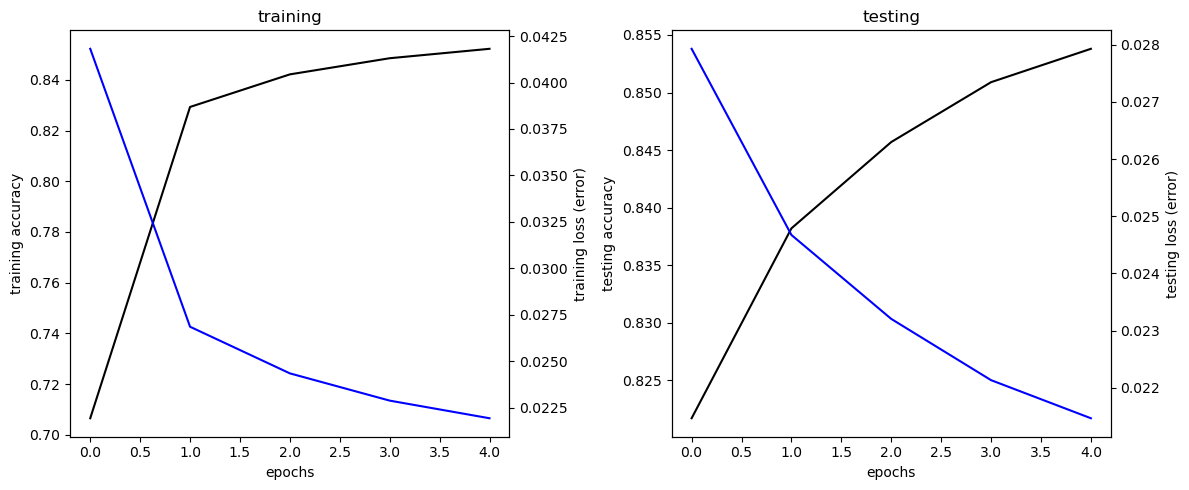

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'], c='k')
plt.ylabel('training accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(model.history.history['loss'], c='b')
plt.ylabel('training loss (error)')
plt.title('training')

plt.subplot(1, 2, 2)
plt.plot(model.history.history['val_accuracy'], c='k')
plt.ylabel('testing accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(model.history.history['val_loss'], c='b')
plt.ylabel('testing loss (error)')
plt.title('testing')
plt.tight_layout()
plt.show()

Now let's see how well it performs on the test set.

313/313 [==============================] - 0s 379us/step


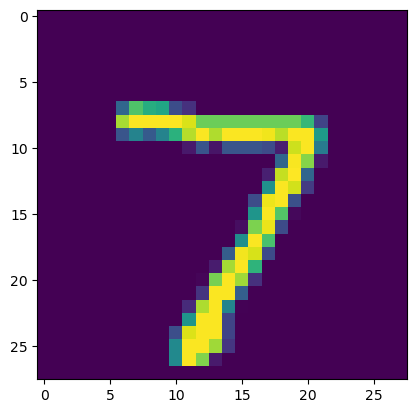

actual output from network: [0.        0.        0.        0.        0.        0.        0.
 0.8715112 0.        0.       ]
category (the largest output): 7


In [19]:
output = model.predict(x_test)
category = np.argmax(output, axis=1)

plt.imshow(x_test[0])
plt.show()
print('actual output from network:', output[0])
print('category (the largest output):', category[0])

Well it learned the first item well, but it's only getting around 85% on the test set (which is also about what it's getting on the training set).  To get a better sense of what it's doing, let's generate the *confusion* matrix.  This indicates what category it puts things in, as compared to what category they should be in.

In [21]:
confusion=np.zeros((10,10), dtype=int)
np.add.at(confusion, (category, y_test), 1)
print(confusion)

[[ 966    1   16  403    2   12   11    2    7   13]
 [   0 1114    2    7    1    1    3   15    2    5]
 [   2    4  967   78    6    2    2   13    7    1]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    6    6  935    4    9    5    8   26]
 [   4    1    5  255    0  838   18    3   17    6]
 [   3    6    5    6    9   11  909    0    5    1]
 [   1    1   10   43    2    3    1  973   13   14]
 [   4    8   18  189    4   15    5    0  908   15]
 [   0    0    3   23   23    6    0   17    7  928]]


The ideal confusion matrix will have ~1000 along the diagonal and 0 everywhere else.  According to this confusion matrix (yours will be different), 9's got mis-calssified as 4's a lot (and vice-versa).

**1. [1 mark]:** Run the MNIST model as defined here 10 times.  Note that you have to re-create the `model` each time: if you just run `model.fit` over again, then it will just train the same model, continuing from where it left off.  Each of the 10 models should be trained for 5 epochs.  Make a single plot with training accuracy vs epoch for all 10 runs. You should see that each time you train the model, it behaves differently.  Why does this happen? 

Epoch 1/5
1875/1875 [==============================] - 1s 695us/step - loss: 0.0571 - accuracy: 0.5290 - val_loss: 0.0509 - val_accuracy: 0.5615
Epoch 2/5
1875/1875 [==============================] - 1s 520us/step - loss: 0.0504 - accuracy: 0.5655 - val_loss: 0.0492 - val_accuracy: 0.5675
Epoch 3/5
1875/1875 [==============================] - 1s 526us/step - loss: 0.0490 - accuracy: 0.5695 - val_loss: 0.0483 - val_accuracy: 0.5709
Epoch 4/5
1875/1875 [==============================] - 1s 652us/step - loss: 0.0482 - accuracy: 0.5727 - val_loss: 0.0477 - val_accuracy: 0.5724
Epoch 5/5
1875/1875 [==============================] - 1s 542us/step - loss: 0.0476 - accuracy: 0.5747 - val_loss: 0.0472 - val_accuracy: 0.5745
Epoch 1/5
1875/1875 [==============================] - 1s 562us/step - loss: 0.0393 - accuracy: 0.7403 - val_loss: 0.0274 - val_accuracy: 0.8301
Epoch 2/5
1875/1875 [==============================] - 1s 540us/step - loss: 0.0264 - accuracy: 0.8328 - val_loss: 0.0243 - val_ac

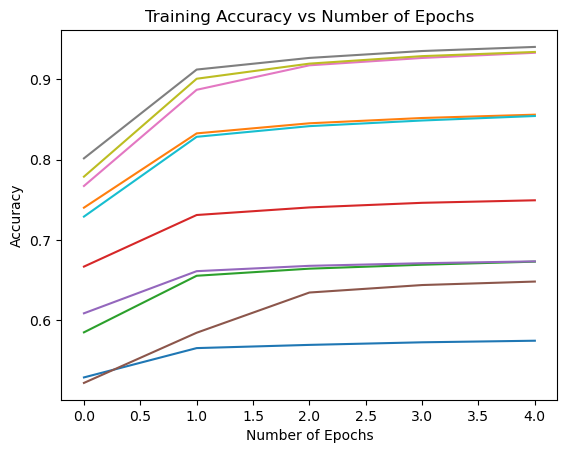

In [32]:
plt.figure()
for i in range(10):
    # Create new model
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
      tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
      tf.keras.layers.Dense(10, activation='relu')     # 10 outputs (one for each category)
    ])
    
    # Compile model
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), # use stochastic gradient descent
                  loss=my_loss,
                  metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                 )
    
    # Train each model for 5 epochs
    history = model.fit(x_train, y_train_target, epochs=5, validation_data=(x_test, y_test_target));
    
    # Plot the training accuracy on the same graph
    plt.plot(history.history['accuracy'])

plt.title("Training Accuracy vs Number of Epochs")
plt.ylabel("Training Accuracy")
plt.xlabel("Number of Epochs")
plt.show()

The reason each model behaves differently is because each model is initialized with random weights. The differences in the starting weights lead to different outcomes. Furthermore, the SGD optimizer is stochastic, which means that they introduce randomness while updating the parameters. These factors lead to the model behaving differently each time it is trained.

**2. [1 mark]:** Do the same thing as question 1, but train for 20 epochs.  Plot the training error vs epochs for 10 different runs on one plot.  On a separate plot show the testing error vs epochs for the 10 different runs.  How does the testing error compare to the training error?  Do the models all eventually learn to solve the problem well?  What happens to them?

Epoch 1/20
1875/1875 [==============================] - 1s 718us/step - loss: 0.0356 - accuracy: 0.7671 - val_loss: 0.0262 - val_accuracy: 0.8329
Epoch 2/20
1875/1875 [==============================] - 1s 637us/step - loss: 0.0251 - accuracy: 0.8378 - val_loss: 0.0237 - val_accuracy: 0.8433
Epoch 3/20
1875/1875 [==============================] - 1s 628us/step - loss: 0.0230 - accuracy: 0.8480 - val_loss: 0.0222 - val_accuracy: 0.8516
Epoch 4/20
1875/1875 [==============================] - 1s 534us/step - loss: 0.0217 - accuracy: 0.8543 - val_loss: 0.0213 - val_accuracy: 0.8569
Epoch 5/20
1875/1875 [==============================] - 1s 534us/step - loss: 0.0209 - accuracy: 0.8581 - val_loss: 0.0207 - val_accuracy: 0.8580
Epoch 6/20
1875/1875 [==============================] - 1s 537us/step - loss: 0.0203 - accuracy: 0.8612 - val_loss: 0.0203 - val_accuracy: 0.8600
Epoch 7/20
1875/1875 [==============================] - 1s 533us/step - loss: 0.0198 - accuracy: 0.8634 - val_loss: 0.0197 -

Epoch 1/20
1875/1875 [==============================] - 1s 578us/step - loss: 0.0502 - accuracy: 0.6604 - val_loss: 0.0398 - val_accuracy: 0.7488
Epoch 2/20
1875/1875 [==============================] - 1s 542us/step - loss: 0.0378 - accuracy: 0.7715 - val_loss: 0.0361 - val_accuracy: 0.7939
Epoch 3/20
1875/1875 [==============================] - 1s 533us/step - loss: 0.0352 - accuracy: 0.7936 - val_loss: 0.0342 - val_accuracy: 0.8041
Epoch 4/20
1875/1875 [==============================] - 1s 532us/step - loss: 0.0337 - accuracy: 0.8055 - val_loss: 0.0332 - val_accuracy: 0.8135
Epoch 5/20
1875/1875 [==============================] - 1s 531us/step - loss: 0.0326 - accuracy: 0.8119 - val_loss: 0.0325 - val_accuracy: 0.8153
Epoch 6/20
1875/1875 [==============================] - 1s 531us/step - loss: 0.0319 - accuracy: 0.8164 - val_loss: 0.0318 - val_accuracy: 0.8152
Epoch 7/20
1875/1875 [==============================] - 1s 532us/step - loss: 0.0313 - accuracy: 0.8187 - val_loss: 0.0314 -

Epoch 1/20
1875/1875 [==============================] - 1s 580us/step - loss: 0.0318 - accuracy: 0.8276 - val_loss: 0.0204 - val_accuracy: 0.9038
Epoch 2/20
1875/1875 [==============================] - 1s 536us/step - loss: 0.0191 - accuracy: 0.9135 - val_loss: 0.0168 - val_accuracy: 0.9265
Epoch 3/20
1875/1875 [==============================] - 1s 536us/step - loss: 0.0165 - accuracy: 0.9267 - val_loss: 0.0152 - val_accuracy: 0.9332
Epoch 4/20
1875/1875 [==============================] - 1s 537us/step - loss: 0.0150 - accuracy: 0.9347 - val_loss: 0.0143 - val_accuracy: 0.9381
Epoch 5/20
1875/1875 [==============================] - 1s 536us/step - loss: 0.0139 - accuracy: 0.9394 - val_loss: 0.0133 - val_accuracy: 0.9419
Epoch 6/20
1875/1875 [==============================] - 1s 533us/step - loss: 0.0131 - accuracy: 0.9434 - val_loss: 0.0128 - val_accuracy: 0.9443
Epoch 7/20
1875/1875 [==============================] - 1s 534us/step - loss: 0.0124 - accuracy: 0.9468 - val_loss: 0.0123 -

Epoch 1/20
1875/1875 [==============================] - 1s 574us/step - loss: 0.0503 - accuracy: 0.6256 - val_loss: 0.0383 - val_accuracy: 0.7169
Epoch 2/20
1875/1875 [==============================] - 1s 532us/step - loss: 0.0378 - accuracy: 0.7179 - val_loss: 0.0356 - val_accuracy: 0.7337
Epoch 3/20
1875/1875 [==============================] - 1s 544us/step - loss: 0.0355 - accuracy: 0.7305 - val_loss: 0.0342 - val_accuracy: 0.7395
Epoch 4/20
1875/1875 [==============================] - 1s 555us/step - loss: 0.0341 - accuracy: 0.7366 - val_loss: 0.0331 - val_accuracy: 0.7430
Epoch 5/20
1875/1875 [==============================] - 1s 533us/step - loss: 0.0331 - accuracy: 0.7413 - val_loss: 0.0325 - val_accuracy: 0.7445
Epoch 6/20
1875/1875 [==============================] - 1s 531us/step - loss: 0.0324 - accuracy: 0.7446 - val_loss: 0.0320 - val_accuracy: 0.7461
Epoch 7/20
1875/1875 [==============================] - 1s 531us/step - loss: 0.0319 - accuracy: 0.7469 - val_loss: 0.0315 -

Epoch 1/20
1875/1875 [==============================] - 1s 574us/step - loss: 0.0517 - accuracy: 0.5942 - val_loss: 0.0434 - val_accuracy: 0.6499
Epoch 2/20
1875/1875 [==============================] - 1s 536us/step - loss: 0.0373 - accuracy: 0.7141 - val_loss: 0.0328 - val_accuracy: 0.7516
Epoch 3/20
1875/1875 [==============================] - 1s 534us/step - loss: 0.0320 - accuracy: 0.7556 - val_loss: 0.0312 - val_accuracy: 0.7574
Epoch 4/20
1875/1875 [==============================] - 1s 535us/step - loss: 0.0306 - accuracy: 0.7614 - val_loss: 0.0303 - val_accuracy: 0.7602
Epoch 5/20
1875/1875 [==============================] - 1s 535us/step - loss: 0.0297 - accuracy: 0.7655 - val_loss: 0.0295 - val_accuracy: 0.7634
Epoch 6/20
1875/1875 [==============================] - 1s 535us/step - loss: 0.0290 - accuracy: 0.7686 - val_loss: 0.0291 - val_accuracy: 0.7643
Epoch 7/20
1875/1875 [==============================] - 1s 634us/step - loss: 0.0285 - accuracy: 0.7704 - val_loss: 0.0288 -

Epoch 1/20
1875/1875 [==============================] - 1s 577us/step - loss: 0.0480 - accuracy: 0.6520 - val_loss: 0.0332 - val_accuracy: 0.7903
Epoch 2/20
1875/1875 [==============================] - 1s 531us/step - loss: 0.0275 - accuracy: 0.8263 - val_loss: 0.0248 - val_accuracy: 0.8410
Epoch 3/20
1875/1875 [==============================] - 1s 531us/step - loss: 0.0242 - accuracy: 0.8434 - val_loss: 0.0230 - val_accuracy: 0.8498
Epoch 4/20
1875/1875 [==============================] - 1s 531us/step - loss: 0.0227 - accuracy: 0.8507 - val_loss: 0.0220 - val_accuracy: 0.8556
Epoch 5/20
1875/1875 [==============================] - 1s 530us/step - loss: 0.0217 - accuracy: 0.8548 - val_loss: 0.0213 - val_accuracy: 0.8589
Epoch 6/20
1875/1875 [==============================] - 1s 530us/step - loss: 0.0210 - accuracy: 0.8584 - val_loss: 0.0207 - val_accuracy: 0.8607
Epoch 7/20
1875/1875 [==============================] - 1s 536us/step - loss: 0.0205 - accuracy: 0.8605 - val_loss: 0.0203 -

Epoch 1/20
1875/1875 [==============================] - 1s 584us/step - loss: 0.0407 - accuracy: 0.7509 - val_loss: 0.0285 - val_accuracy: 0.8633
Epoch 2/20
1875/1875 [==============================] - 1s 538us/step - loss: 0.0270 - accuracy: 0.8789 - val_loss: 0.0249 - val_accuracy: 0.9009
Epoch 3/20
1875/1875 [==============================] - 1s 536us/step - loss: 0.0244 - accuracy: 0.9015 - val_loss: 0.0232 - val_accuracy: 0.9062
Epoch 4/20
1875/1875 [==============================] - 1s 536us/step - loss: 0.0230 - accuracy: 0.9119 - val_loss: 0.0223 - val_accuracy: 0.9145
Epoch 5/20
1875/1875 [==============================] - 1s 558us/step - loss: 0.0221 - accuracy: 0.9183 - val_loss: 0.0215 - val_accuracy: 0.9222
Epoch 6/20
1875/1875 [==============================] - 1s 541us/step - loss: 0.0214 - accuracy: 0.9234 - val_loss: 0.0210 - val_accuracy: 0.9247
Epoch 7/20
1875/1875 [==============================] - 1s 536us/step - loss: 0.0209 - accuracy: 0.9266 - val_loss: 0.0207 -

Epoch 1/20
1875/1875 [==============================] - 1s 588us/step - loss: 0.0329 - accuracy: 0.8098 - val_loss: 0.0197 - val_accuracy: 0.9104
Epoch 2/20
1875/1875 [==============================] - 1s 532us/step - loss: 0.0187 - accuracy: 0.9161 - val_loss: 0.0166 - val_accuracy: 0.9267
Epoch 3/20
1875/1875 [==============================] - 1s 532us/step - loss: 0.0160 - accuracy: 0.9300 - val_loss: 0.0149 - val_accuracy: 0.9323
Epoch 4/20
1875/1875 [==============================] - 1s 531us/step - loss: 0.0145 - accuracy: 0.9371 - val_loss: 0.0138 - val_accuracy: 0.9397
Epoch 5/20
1875/1875 [==============================] - 1s 592us/step - loss: 0.0135 - accuracy: 0.9421 - val_loss: 0.0131 - val_accuracy: 0.9412
Epoch 6/20
1875/1875 [==============================] - 1s 531us/step - loss: 0.0127 - accuracy: 0.9459 - val_loss: 0.0125 - val_accuracy: 0.9452
Epoch 7/20
1875/1875 [==============================] - 1s 549us/step - loss: 0.0121 - accuracy: 0.9486 - val_loss: 0.0120 -

Epoch 1/20
1875/1875 [==============================] - 1s 573us/step - loss: 0.0466 - accuracy: 0.6934 - val_loss: 0.0373 - val_accuracy: 0.7828
Epoch 2/20
1875/1875 [==============================] - 1s 531us/step - loss: 0.0366 - accuracy: 0.7856 - val_loss: 0.0343 - val_accuracy: 0.8025
Epoch 3/20
1875/1875 [==============================] - 1s 547us/step - loss: 0.0342 - accuracy: 0.8022 - val_loss: 0.0328 - val_accuracy: 0.8085
Epoch 4/20
1875/1875 [==============================] - 1s 531us/step - loss: 0.0328 - accuracy: 0.8122 - val_loss: 0.0319 - val_accuracy: 0.8196
Epoch 5/20
1875/1875 [==============================] - 1s 530us/step - loss: 0.0318 - accuracy: 0.8195 - val_loss: 0.0311 - val_accuracy: 0.8254
Epoch 6/20
1875/1875 [==============================] - 1s 530us/step - loss: 0.0311 - accuracy: 0.8243 - val_loss: 0.0306 - val_accuracy: 0.8298
Epoch 7/20
1875/1875 [==============================] - 1s 530us/step - loss: 0.0306 - accuracy: 0.8277 - val_loss: 0.0302 -

Epoch 1/20
1875/1875 [==============================] - 1s 569us/step - loss: 0.0396 - accuracy: 0.7338 - val_loss: 0.0289 - val_accuracy: 0.8171
Epoch 2/20
1875/1875 [==============================] - 1s 534us/step - loss: 0.0273 - accuracy: 0.8261 - val_loss: 0.0255 - val_accuracy: 0.8322
Epoch 3/20
1875/1875 [==============================] - 1s 533us/step - loss: 0.0247 - accuracy: 0.8386 - val_loss: 0.0239 - val_accuracy: 0.8422
Epoch 4/20
1875/1875 [==============================] - 1s 533us/step - loss: 0.0233 - accuracy: 0.8447 - val_loss: 0.0228 - val_accuracy: 0.8458
Epoch 5/20
1875/1875 [==============================] - 1s 539us/step - loss: 0.0223 - accuracy: 0.8497 - val_loss: 0.0223 - val_accuracy: 0.8497
Epoch 6/20
1875/1875 [==============================] - 1s 540us/step - loss: 0.0216 - accuracy: 0.8530 - val_loss: 0.0216 - val_accuracy: 0.8520
Epoch 7/20
1875/1875 [==============================] - 1s 558us/step - loss: 0.0210 - accuracy: 0.8562 - val_loss: 0.0211 -

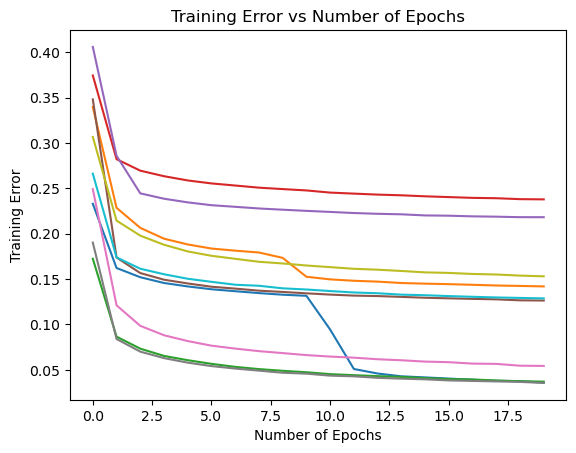

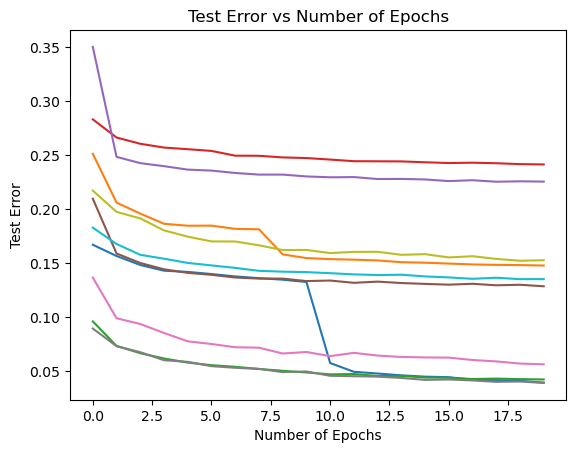

In [35]:
import numpy as np

train_errs = []
test_errs = []

def get_error(accuracy):
    return 1 - accuracy

err_func = np.vectorize(get_error)

num_models = 10

for i in range(num_models):
    # Create new model
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
      tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
      tf.keras.layers.Dense(10, activation='relu')     # 10 outputs (one for each category)
    ])
    
    # Compile model
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), # use stochastic gradient descent
                  loss=my_loss,
                  metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                 )
    
    # Train each model for 20 epochs
    history = model.fit(x_train, y_train_target, epochs=20, validation_data=(x_test, y_test_target));
    
    # Store training and test errors
    train_err = err_func(history.history['accuracy'])
    train_errs.append(train_err)
    
    test_err = err_func(history.history['val_accuracy'])
    test_errs.append(test_err)

# Plot training errors
plt.figure()
for i in range(num_models):
    plt.plot(train_errs[i])
plt.title("Training Error vs Number of Epochs")
plt.ylabel("Training Error")
plt.xlabel("Number of Epochs")
plt.show()

# Plot test errors
plt.figure()
for i in range(num_models):
    plt.plot(test_errs[i])
plt.title("Test Error vs Number of Epochs")
plt.ylabel("Test Error")
plt.xlabel("Number of Epochs")
plt.show()

The testing error and training errors seem fairly similar when comparing the two graphs. Furthermore, while each model seems to follow the same shape in how the error changes over the 20 epochs, only some of the models actually end up learning the model well. That is, each model converges to a different final training and test error. This can again be associated with the random weights that each model begins with, which leads to each model converging to a different local minima.

**3. [1 mark]:** Repeat question 2 (generating the same 2 plots), but with a learning rate of 0.01.  How does this affect the learning performance?

Epoch 1/20
1875/1875 [==============================] - 2s 737us/step - loss: 0.0746 - accuracy: 0.4463 - val_loss: 0.0551 - val_accuracy: 0.6352
Epoch 2/20
1875/1875 [==============================] - 1s 541us/step - loss: 0.0461 - accuracy: 0.7174 - val_loss: 0.0383 - val_accuracy: 0.7803
Epoch 3/20
1875/1875 [==============================] - 1s 549us/step - loss: 0.0366 - accuracy: 0.7879 - val_loss: 0.0333 - val_accuracy: 0.8054
Epoch 4/20
1875/1875 [==============================] - 1s 539us/step - loss: 0.0328 - accuracy: 0.8120 - val_loss: 0.0307 - val_accuracy: 0.8249
Epoch 5/20
1875/1875 [==============================] - 1s 538us/step - loss: 0.0305 - accuracy: 0.8279 - val_loss: 0.0289 - val_accuracy: 0.8382
Epoch 6/20
1875/1875 [==============================] - 1s 537us/step - loss: 0.0288 - accuracy: 0.8395 - val_loss: 0.0274 - val_accuracy: 0.8490
Epoch 7/20
1875/1875 [==============================] - 1s 570us/step - loss: 0.0274 - accuracy: 0.8515 - val_loss: 0.0259 -

Epoch 1/20
1875/1875 [==============================] - 1s 581us/step - loss: 0.0812 - accuracy: 0.3498 - val_loss: 0.0663 - val_accuracy: 0.5131
Epoch 2/20
1875/1875 [==============================] - 1s 552us/step - loss: 0.0606 - accuracy: 0.5591 - val_loss: 0.0551 - val_accuracy: 0.6040
Epoch 3/20
1875/1875 [==============================] - 1s 601us/step - loss: 0.0540 - accuracy: 0.6158 - val_loss: 0.0509 - val_accuracy: 0.6459
Epoch 4/20
1875/1875 [==============================] - 1s 537us/step - loss: 0.0464 - accuracy: 0.6779 - val_loss: 0.0423 - val_accuracy: 0.7052
Epoch 5/20
1875/1875 [==============================] - 1s 544us/step - loss: 0.0421 - accuracy: 0.7052 - val_loss: 0.0400 - val_accuracy: 0.7190
Epoch 6/20
1875/1875 [==============================] - 1s 534us/step - loss: 0.0402 - accuracy: 0.7149 - val_loss: 0.0385 - val_accuracy: 0.7284
Epoch 7/20
1875/1875 [==============================] - 1s 536us/step - loss: 0.0390 - accuracy: 0.7208 - val_loss: 0.0375 -

Epoch 1/20
1875/1875 [==============================] - 1s 578us/step - loss: 0.0766 - accuracy: 0.4056 - val_loss: 0.0587 - val_accuracy: 0.5883
Epoch 2/20
1875/1875 [==============================] - 1s 535us/step - loss: 0.0502 - accuracy: 0.6701 - val_loss: 0.0436 - val_accuracy: 0.7219
Epoch 3/20
1875/1875 [==============================] - 1s 534us/step - loss: 0.0417 - accuracy: 0.7339 - val_loss: 0.0388 - val_accuracy: 0.7533
Epoch 4/20
1875/1875 [==============================] - 1s 536us/step - loss: 0.0380 - accuracy: 0.7574 - val_loss: 0.0361 - val_accuracy: 0.7696
Epoch 5/20
1875/1875 [==============================] - 1s 536us/step - loss: 0.0358 - accuracy: 0.7707 - val_loss: 0.0343 - val_accuracy: 0.7792
Epoch 6/20
1875/1875 [==============================] - 1s 535us/step - loss: 0.0343 - accuracy: 0.7800 - val_loss: 0.0331 - val_accuracy: 0.7841
Epoch 7/20
1875/1875 [==============================] - 1s 535us/step - loss: 0.0331 - accuracy: 0.7860 - val_loss: 0.0321 -

Epoch 1/20
1875/1875 [==============================] - 1s 579us/step - loss: 0.0720 - accuracy: 0.4503 - val_loss: 0.0578 - val_accuracy: 0.5784
Epoch 2/20
1875/1875 [==============================] - 1s 537us/step - loss: 0.0533 - accuracy: 0.6096 - val_loss: 0.0473 - val_accuracy: 0.6662
Epoch 3/20
1875/1875 [==============================] - 1s 534us/step - loss: 0.0442 - accuracy: 0.6886 - val_loss: 0.0412 - val_accuracy: 0.7086
Epoch 4/20
1875/1875 [==============================] - 1s 533us/step - loss: 0.0405 - accuracy: 0.7112 - val_loss: 0.0389 - val_accuracy: 0.7210
Epoch 5/20
1875/1875 [==============================] - 1s 537us/step - loss: 0.0386 - accuracy: 0.7225 - val_loss: 0.0374 - val_accuracy: 0.7295
Epoch 6/20
1875/1875 [==============================] - 1s 532us/step - loss: 0.0373 - accuracy: 0.7303 - val_loss: 0.0364 - val_accuracy: 0.7360
Epoch 7/20
1875/1875 [==============================] - 1s 532us/step - loss: 0.0364 - accuracy: 0.7357 - val_loss: 0.0356 -

Epoch 1/20
1875/1875 [==============================] - 1s 581us/step - loss: 0.0681 - accuracy: 0.5259 - val_loss: 0.0442 - val_accuracy: 0.7546
Epoch 2/20
1875/1875 [==============================] - 1s 534us/step - loss: 0.0381 - accuracy: 0.7918 - val_loss: 0.0327 - val_accuracy: 0.8316
Epoch 3/20
1875/1875 [==============================] - 1s 542us/step - loss: 0.0308 - accuracy: 0.8410 - val_loss: 0.0282 - val_accuracy: 0.8600
Epoch 4/20
1875/1875 [==============================] - 1s 555us/step - loss: 0.0275 - accuracy: 0.8630 - val_loss: 0.0257 - val_accuracy: 0.8772
Epoch 5/20
1875/1875 [==============================] - 1s 533us/step - loss: 0.0255 - accuracy: 0.8764 - val_loss: 0.0240 - val_accuracy: 0.8871
Epoch 6/20
1875/1875 [==============================] - 1s 538us/step - loss: 0.0240 - accuracy: 0.8856 - val_loss: 0.0228 - val_accuracy: 0.8928
Epoch 7/20
1875/1875 [==============================] - 1s 547us/step - loss: 0.0230 - accuracy: 0.8917 - val_loss: 0.0219 -

Epoch 1/20
1875/1875 [==============================] - 1s 587us/step - loss: 0.0740 - accuracy: 0.4469 - val_loss: 0.0545 - val_accuracy: 0.6361
Epoch 2/20
1875/1875 [==============================] - 1s 534us/step - loss: 0.0465 - accuracy: 0.7013 - val_loss: 0.0398 - val_accuracy: 0.7566
Epoch 3/20
1875/1875 [==============================] - 1s 532us/step - loss: 0.0381 - accuracy: 0.7665 - val_loss: 0.0348 - val_accuracy: 0.7950
Epoch 4/20
1875/1875 [==============================] - 1s 534us/step - loss: 0.0344 - accuracy: 0.7914 - val_loss: 0.0322 - val_accuracy: 0.8105
Epoch 5/20
1875/1875 [==============================] - 1s 533us/step - loss: 0.0323 - accuracy: 0.8052 - val_loss: 0.0305 - val_accuracy: 0.8210
Epoch 6/20
1875/1875 [==============================] - 1s 564us/step - loss: 0.0308 - accuracy: 0.8143 - val_loss: 0.0292 - val_accuracy: 0.8289
Epoch 7/20
1875/1875 [==============================] - 1s 534us/step - loss: 0.0297 - accuracy: 0.8215 - val_loss: 0.0283 -

Epoch 1/20
1875/1875 [==============================] - 2s 862us/step - loss: 0.0776 - accuracy: 0.3936 - val_loss: 0.0612 - val_accuracy: 0.5786
Epoch 2/20
1875/1875 [==============================] - 1s 560us/step - loss: 0.0530 - accuracy: 0.6416 - val_loss: 0.0472 - val_accuracy: 0.6886
Epoch 3/20
1875/1875 [==============================] - 1s 537us/step - loss: 0.0458 - accuracy: 0.7042 - val_loss: 0.0432 - val_accuracy: 0.7268
Epoch 4/20
1875/1875 [==============================] - 1s 535us/step - loss: 0.0430 - accuracy: 0.7306 - val_loss: 0.0412 - val_accuracy: 0.7465
Epoch 5/20
1875/1875 [==============================] - 1s 535us/step - loss: 0.0413 - accuracy: 0.7471 - val_loss: 0.0399 - val_accuracy: 0.7568
Epoch 6/20
1875/1875 [==============================] - 1s 535us/step - loss: 0.0400 - accuracy: 0.7573 - val_loss: 0.0388 - val_accuracy: 0.7664
Epoch 7/20
1875/1875 [==============================] - 1s 535us/step - loss: 0.0391 - accuracy: 0.7652 - val_loss: 0.0380 -

Epoch 1/20
1875/1875 [==============================] - 1s 573us/step - loss: 0.0766 - accuracy: 0.4066 - val_loss: 0.0584 - val_accuracy: 0.5892
Epoch 2/20
1875/1875 [==============================] - 1s 535us/step - loss: 0.0509 - accuracy: 0.6632 - val_loss: 0.0429 - val_accuracy: 0.7388
Epoch 3/20
1875/1875 [==============================] - 1s 535us/step - loss: 0.0406 - accuracy: 0.7593 - val_loss: 0.0369 - val_accuracy: 0.7895
Epoch 4/20
1875/1875 [==============================] - 1s 559us/step - loss: 0.0365 - accuracy: 0.7941 - val_loss: 0.0342 - val_accuracy: 0.8122
Epoch 5/20
1875/1875 [==============================] - 1s 554us/step - loss: 0.0342 - accuracy: 0.8137 - val_loss: 0.0324 - val_accuracy: 0.8297
Epoch 6/20
1875/1875 [==============================] - 1s 535us/step - loss: 0.0328 - accuracy: 0.8283 - val_loss: 0.0312 - val_accuracy: 0.8404
Epoch 7/20
1875/1875 [==============================] - 1s 535us/step - loss: 0.0317 - accuracy: 0.8385 - val_loss: 0.0303 -

Epoch 1/20
1875/1875 [==============================] - 1s 580us/step - loss: 0.0719 - accuracy: 0.4564 - val_loss: 0.0494 - val_accuracy: 0.6874
Epoch 2/20
1875/1875 [==============================] - 1s 537us/step - loss: 0.0418 - accuracy: 0.7536 - val_loss: 0.0354 - val_accuracy: 0.8102
Epoch 3/20
1875/1875 [==============================] - 1s 535us/step - loss: 0.0338 - accuracy: 0.8176 - val_loss: 0.0306 - val_accuracy: 0.8394
Epoch 4/20
1875/1875 [==============================] - 1s 534us/step - loss: 0.0302 - accuracy: 0.8399 - val_loss: 0.0280 - val_accuracy: 0.8549
Epoch 5/20
1875/1875 [==============================] - 1s 533us/step - loss: 0.0279 - accuracy: 0.8548 - val_loss: 0.0261 - val_accuracy: 0.8678
Epoch 6/20
1875/1875 [==============================] - 1s 535us/step - loss: 0.0262 - accuracy: 0.8650 - val_loss: 0.0247 - val_accuracy: 0.8771
Epoch 7/20
1875/1875 [==============================] - 1s 535us/step - loss: 0.0248 - accuracy: 0.8746 - val_loss: 0.0234 -

Epoch 1/20
1875/1875 [==============================] - 1s 583us/step - loss: 0.0800 - accuracy: 0.3736 - val_loss: 0.0597 - val_accuracy: 0.5816
Epoch 2/20
1875/1875 [==============================] - 1s 537us/step - loss: 0.0521 - accuracy: 0.6387 - val_loss: 0.0469 - val_accuracy: 0.6700
Epoch 3/20
1875/1875 [==============================] - 1s 537us/step - loss: 0.0456 - accuracy: 0.6791 - val_loss: 0.0436 - val_accuracy: 0.6870
Epoch 4/20
1875/1875 [==============================] - 1s 541us/step - loss: 0.0432 - accuracy: 0.6928 - val_loss: 0.0420 - val_accuracy: 0.6976
Epoch 5/20
1875/1875 [==============================] - 1s 538us/step - loss: 0.0417 - accuracy: 0.7011 - val_loss: 0.0409 - val_accuracy: 0.7061
Epoch 6/20
1875/1875 [==============================] - 1s 537us/step - loss: 0.0407 - accuracy: 0.7072 - val_loss: 0.0400 - val_accuracy: 0.7102
Epoch 7/20
1875/1875 [==============================] - 1s 537us/step - loss: 0.0399 - accuracy: 0.7123 - val_loss: 0.0394 -

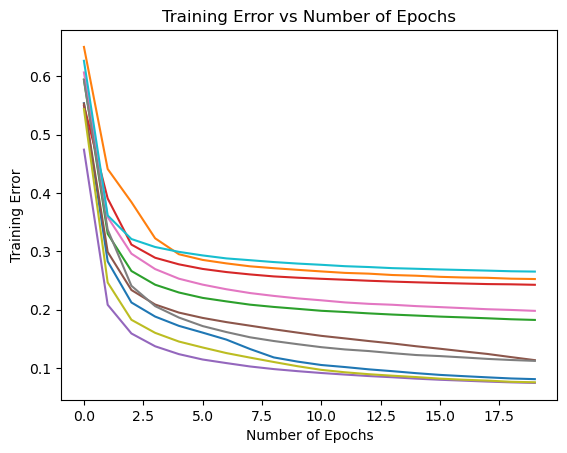

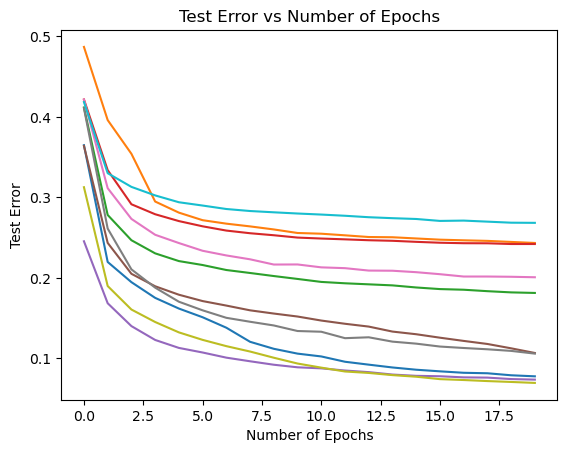

In [36]:
import numpy as np

train_errs = []
test_errs = []

def get_error(accuracy):
    return 1 - accuracy

err_func = np.vectorize(get_error)

num_models = 10

for i in range(num_models):
    # Create new model
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
      tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
      tf.keras.layers.Dense(10, activation='relu')     # 10 outputs (one for each category)
    ])
    
    # Compile model
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), # use stochastic gradient descent
                  loss=my_loss,
                  metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                 )
    
    # Train each model for 20 epochs
    history = model.fit(x_train, y_train_target, epochs=20, validation_data=(x_test, y_test_target));
    
    # Store training and test errors
    train_err = err_func(history.history['accuracy'])
    train_errs.append(train_err)
    
    test_err = err_func(history.history['val_accuracy'])
    test_errs.append(test_err)

# Plot training errors
plt.figure()
for i in range(num_models):
    plt.plot(train_errs[i])
plt.title("Training Error vs Number of Epochs")
plt.ylabel("Training Error")
plt.xlabel("Number of Epochs")
plt.show()

# Plot test errors
plt.figure()
for i in range(num_models):
    plt.plot(test_errs[i])
plt.title("Test Error vs Number of Epochs")
plt.ylabel("Test Error")
plt.xlabel("Number of Epochs")
plt.show()

While each model still converges to a relatively different final training and test error, the initial training errors for each model is significantly higher. The final training errors for each model seems to be within the same range, meaning that the drop in training error after the first few epochs is much more significant with a learning rate of 0.01 when compared to a learning rate of 0.1.

Furthermore, the errors seem to converge after about 6-7 epochs when the learning rate is 0.01, while the errors seemed to converge after about 3-4 epochs when the learning rate was 0.1. This makes sense, as the learning rate determines how fast the model will update its weights. A larger learning rate can lead to faster convergence, which is evident in this case.

**4. [1 mark]:** Instead of standard Stochastic Gradient Descent, most modern machine learning researchers use a variation of it called Adam that automatically adjusts the learning rate and does a better local estimate of the gradient.  We can switch to this by changing `optimizer=tf.keras.optimizers.SGD(learning_rate=0.1)` to `optimizer="adam"`.  Repeat question 2 (generating the same 2 plots) using the Adam optimizer.  How does this affect the learning performance?

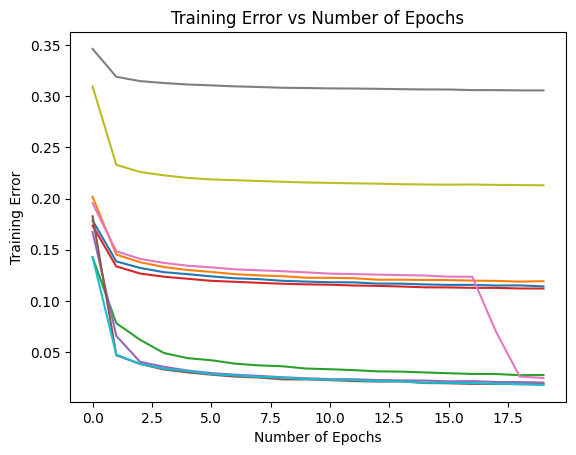

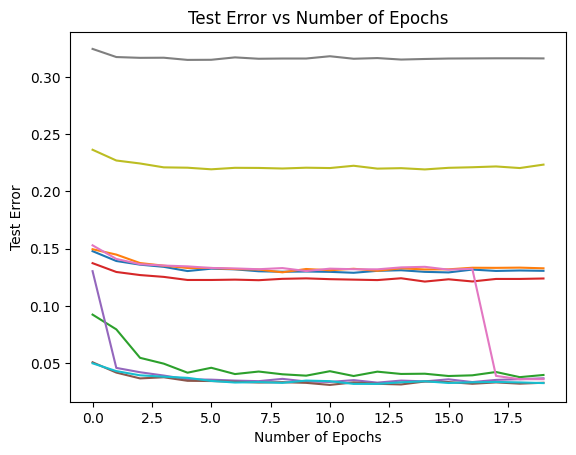

In [6]:
import numpy as np

train_errs = []
test_errs = []

def get_error(accuracy):
    return 1 - accuracy

err_func = np.vectorize(get_error)

num_models = 10

for i in range(num_models):
    # Create new model
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
      tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
      tf.keras.layers.Dense(10, activation='relu')     # 10 outputs (one for each category)
    ])
    
    # Compile model
    model.compile(optimizer="adam", # use stochastic gradient descent
                  loss=my_loss,
                  metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                 )
    
    # Train each model for 20 epochs
    history = model.fit(x_train, y_train_target, epochs=20, validation_data=(x_test, y_test_target), verbose=0);
    
    # Store training and test errors
    train_err = err_func(history.history['accuracy'])
    train_errs.append(train_err)
    
    test_err = err_func(history.history['val_accuracy'])
    test_errs.append(test_err)

# Plot training errors
plt.figure()
for i in range(num_models):
    plt.plot(train_errs[i])
plt.title("Training Error vs Number of Epochs")
plt.ylabel("Training Error")
plt.xlabel("Number of Epochs")
plt.show()

# Plot test errors
plt.figure()
for i in range(num_models):
    plt.plot(test_errs[i])
plt.title("Test Error vs Number of Epochs")
plt.ylabel("Test Error")
plt.xlabel("Number of Epochs")
plt.show()

**5. [1 mark]**: To improve performance, we can also change the output layer of neurons to be a `softmax` layer.  This means that they will automatically be normalized with the softmax function (so the output of neuron $i$ will be ${e^{a_i} / \sum_j e^{a_j}}$).  This should push the output value closer to the sort of output we want (all zeros with a single 1).  Furthermore, instead of doing the error as $(t-y)^2$, we can instead choose an error function that is only concerned about categorization.  After all, the only thing we care about when categorizing is which of the outputs is largest, not whether they are exactly 0 or 1.  Conveniently, tensorflow (and many other deep learning libraries) also contains a version of this function that works directly on category labels, so we don't have to do the `y_train_target = np.eye(10)[y_train]` trick in the code above.  The resulting network looks like this:

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
  tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
  tf.keras.layers.Dense(10, activation='softmax')  # 10 outputs (one for each category)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
             )

model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))   # note that we now use y_train, not y_train_target

Generate the same 2 plots as in question 2.  How do these changes affect the learning performance?

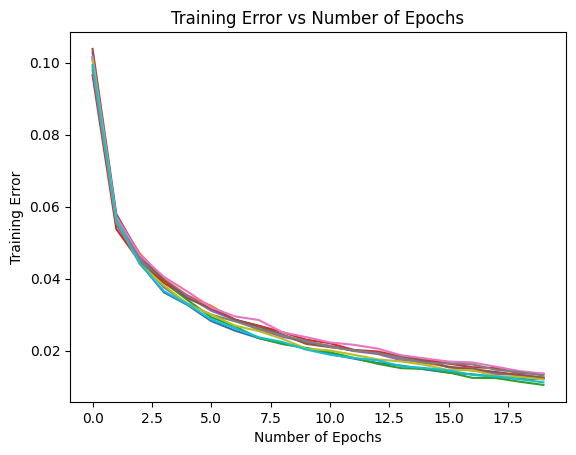

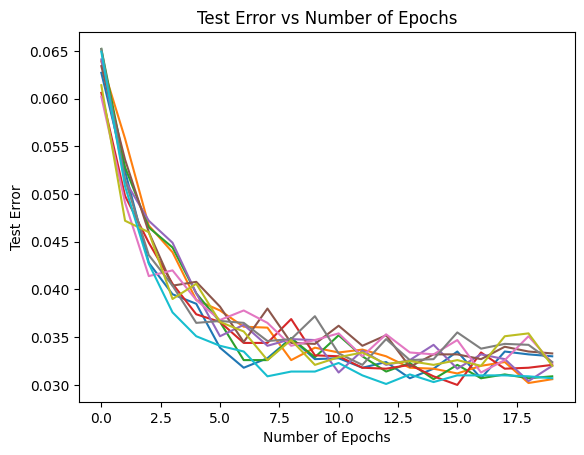

In [7]:
import numpy as np

train_errs = []
test_errs = []

def get_error(accuracy):
    return 1 - accuracy

err_func = np.vectorize(get_error)

num_models = 10

for i in range(num_models):
    # Create new model
    model = tf.keras.models.Sequential([
              tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
              tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
              tf.keras.layers.Dense(10, activation='softmax')  # 10 outputs (one for each category)
            ])
    
    # Compile model
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
             )
    
    # Train each model for 20 epochs
    history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), verbose=0);
    
    # Store training and test errors
    train_err = err_func(history.history['accuracy'])
    train_errs.append(train_err)
    
    test_err = err_func(history.history['val_accuracy'])
    test_errs.append(test_err)

# Plot training errors
plt.figure()
for i in range(num_models):
    plt.plot(train_errs[i])
plt.title("Training Error vs Number of Epochs")
plt.ylabel("Training Error")
plt.xlabel("Number of Epochs")
plt.show()

# Plot test errors
plt.figure()
for i in range(num_models):
    plt.plot(test_errs[i])
plt.title("Test Error vs Number of Epochs")
plt.ylabel("Test Error")
plt.xlabel("Number of Epochs")
plt.show()

After the changes made, all the models perform significantly better, with very low final training and test errors. In addition, they have very similar training and test errors throughout all the epochs, as opposed to before, when each model had relatively different starting and ending training and test errors.

This is likely attributed to the `softmax` activation function that is used in the output layer. While the ReLU activation function is commonly used in hidden layers of neural networks, the `softmax` activation function is often more appropriate in the output layer as it produces a probability distribution over the classes that sum up to 1. This allows us to easily interpret the output as probabilities, which is why multi-class classification problems like this one often have the `softmax` activation function in the output layer.

**6. [2 marks]:** Using the final version of the model (from question 5), explore the performance of the model as you change the number of neurons in the hidden layer.  Try 2, 4, 8, 16, 32, 64, 128, and 256.  For each value, train 10 models for 10 epochs each.  We do not need the testing accuracy over the epochs, so you can switch back to setting `epochs=10` rather than using the `for` loop.  Plot the average training accuracy vs different numbers of neurons.  On a separate plot, plot the average testing accuracy vs different numbers of neurons.  What trend do you observe?

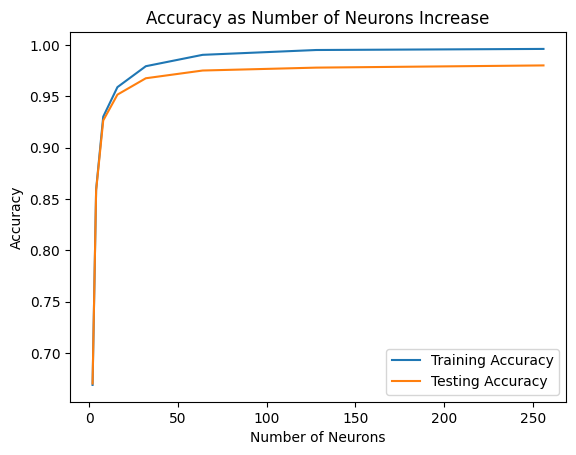

In [17]:
neurons = [2, 4, 8, 16, 32, 64, 128, 256]

final_train_accs = []
final_test_accs = []

plt.figure()

for i in range(len(neurons)):
    total_train_acc = 0
    total_test_acc = 0
    # Train 10 models
    for j in range(10):
        # Create new model
        model = tf.keras.models.Sequential([
                tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
                tf.keras.layers.Dense(neurons[i], activation='relu'),    # 32 neurons in the middle "hidden" layer
                tf.keras.layers.Dense(10, activation='softmax')  # 10 outputs (one for each category)
                ])
        
        # Compile model
        model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                )
        
        # Train each model for 10 epochs
        history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=0);
        
        # Store training and test errors
        total_train_acc += history.history['accuracy'][-1]
        total_test_acc += history.history['val_accuracy'][-1]
    
    # Calculate average accuracy across 10 models
    avg_train_acc = total_train_acc / 10
    avg_test_acc = total_test_acc / 10

    # Plot training accuracies
    final_train_accs.append(avg_train_acc)
    final_test_accs.append(avg_test_acc)

plt.plot(neurons, final_train_accs)
plt.plot(neurons, final_test_accs)
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.title("Accuracy as Number of Neurons Increase")
plt.ylabel("Accuracy")
plt.xlabel("Number of Neurons")
plt.show()



From the above graph, we clearly see that as the number of neurons increases, the training accuracy increases as well. However, the relationship is not linear, and in fact, we see diminishing returns as we increase the number of neurons. This then becomes a question of processing speed, as increasing the number of neurons increases the training accuracy at the cost of computational efficiency. When processing large amounts of data, it may be beneficial to use a lower number of neurons, such as 16 or 32, as that will still allow the model to have a final 

Mention diminishing returns

**7. [2 marks]:** The overall goal is to make the network perform as well as possible on the testing data.  What would you do if your job was to make the best possible network for this task?  Try some things and report your results.  For example, try adding a second hidden layer to the model.  Try making it different sizes. What about having no hidden layer?  Or more than 2?  Report the results of your exploration.

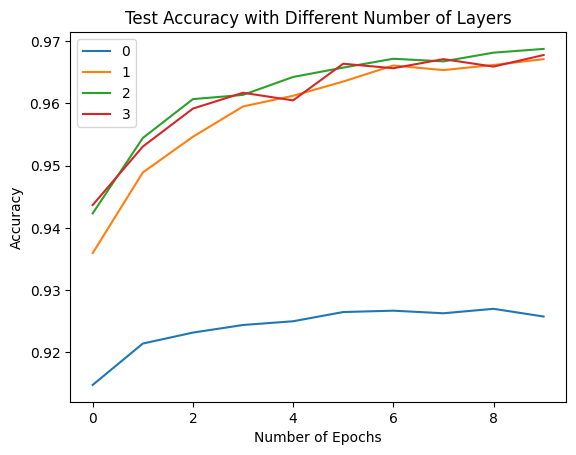

In [18]:
# We first try varying the number of hidden layers
layers = [0, 1, 2, 3]

for i in range(len(layers)):
    total_acc = np.zeros(10)

    # Train 5 models
    for j in range(5):
        # Create new model
        model = tf.keras.models.Sequential()

        model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
        
        for k in range(layers[i]):
            model.add(tf.keras.layers.Dense(32, activation='relu'))
        
        model.add(tf.keras.layers.Dense(10, activation='softmax'))

        # Compile model
        model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                )
        
        # Train each model for 10 epochs
        history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=0);
        
        # Store test errors
        total_acc = np.add(total_acc, history.history['val_accuracy'])

    # Calculate average accuracy across 5 models
    avg_acc = np.divide(total_acc, 5)

    # Plot training accuracies
    plt.plot(avg_acc)

plt.title("Test Accuracy with Different Number of Layers")
plt.legend(layers)
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")
plt.show()


Talk about what's better, pick best number of layers

In [19]:
# We now optimize the number of neurons in each layer
neurons = [8, 32, 64, 128]
num_neurons = len(neurons)

# Store the maximum accuracy and the best number of neurons for each layer as (max_acc, layer1, layer2)
max_acc = (0, 0, 0)

for i in range(num_neurons):
    for j in range(num_neurons):
        total_acc = 0
        # Train 5 neurons
        for k in range(5):
            model = tf.keras.models.Sequential([
                    tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
                    tf.keras.layers.Dense(neurons[i], activation='relu'),    # 32 neurons in the middle "hidden" layer
                    tf.keras.layers.Dense(neurons[j], activation='relu'),    # 32 neurons in the middle "hidden" layer
                    tf.keras.layers.Dense(10, activation='softmax')  # 10 outputs (one for each category)
                    ])
            model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                )
            history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=0);
            total_acc += history.history['val_accuracy'][-1]
        avg_acc = total_acc/5
        if avg_acc > max_acc[0]:
            max_acc = (avg_acc, neurons[i], neurons[j])

print(f"The maximum final test accuracy is {max_acc[0]}, with {max_acc[1]} neurons in the first layer and {max_acc[2]} neurons in the second layer.")

The maximum final test accuracy is 0.978059995174408, with 128 neurons in the first layer and 128 neurons in the second layer.


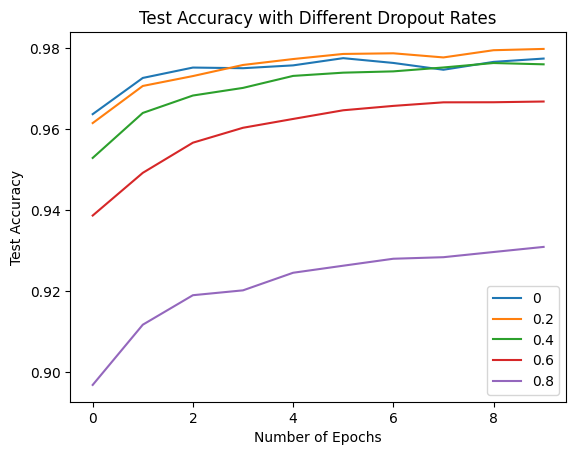

In [20]:
# We now add dropout and vary the dropout rate
dropouts = [0, 0.2, 0.4, 0.6, 0.8]

for i in range(len(dropouts)):
    total_acc = np.zeros(10)

    # Train 5 models
    for j in range(5):
        # Create new model
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
            tf.keras.layers.Dense(128, activation='relu'),    # 32 neurons in the middle "hidden" layer
            tf.keras.layers.Dropout(dropouts[i]),
            tf.keras.layers.Dense(128, activation='relu'),    # 32 neurons in the middle "hidden" layer
            tf.keras.layers.Dropout(dropouts[i]),
            tf.keras.layers.Dense(10, activation='softmax')  # 10 outputs (one for each category)
            ])
        
        # Compile model
        model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
            )
        
        # Train each model for 10 epochs
        history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=0);
        
        # Store test errors
        total_acc = np.add(total_acc, history.history['val_accuracy'])

    # Calculate average accuracy across 5 models
    avg_acc = np.divide(total_acc, 5)

    # Plot training accuracies
    plt.plot(avg_acc)

plt.title("Test Accuracy with Different Dropout Rates")
plt.legend(dropouts)
plt.ylabel("Test Accuracy")
plt.xlabel("Number of Epochs")
plt.show()


## Part 2: CIFAR-10

The CIFAR-10 dataset is a bit harder than the MNIST dataset.  Like MNIST, it consists of 10 categories of images, but now they are colour images and they are of different types of objects.

In [21]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Scale pixel values to be between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0
y_test = y_test[:,0]

170498071/170498071 [==============================] - 5s 0us/step


C:\Users\Calvin Tran\AppData\Local\Temp\ipykernel_20988\1686323551.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(names[int(y_train[i])])


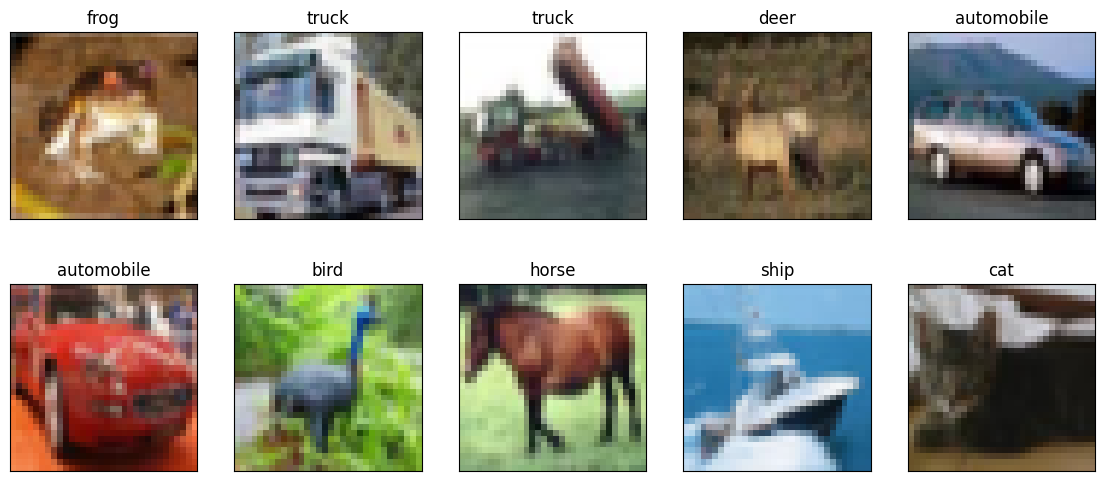

In [22]:
plt.figure(figsize=(14,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(names[int(y_train[i])])
plt.show()

**8. [2 marks]:** Try using the same model as we used for the MNIST (question 5) task to categorize these images.  You will need to change `input_shape=(28, 28)` to `input_shape=(32, 32, 3)`, as these are now colour images of a different size.  Use 32 neurons in the hidden layer and train for 10 epochs.  Do this 10 times and plot the training accuracy and testing accuracy.  How well does the model perform?  Try increasing the number of hidden layer neurons (pick a number of neurons that seems reasonable given how much computer processing power you have).  How much does the system improve?

In [ ]:
import numpy as np

train_accs = []
test_accs = []

num_models = 10

for i in range(num_models):
    # Create new model
    model = tf.keras.models.Sequential([
              tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
              tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
              tf.keras.layers.Dense(10, activation='softmax')  # 10 outputs (one for each category)
            ])
    
    # Compile model
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
             )
    
    # Train each model for 20 epochs
    history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), verbose=0);
    
    # Store training and test errors
    train_err = err_func(history.history['accuracy'])
    train_errs.append(train_err)
    
    test_err = err_func(history.history['val_accuracy'])
    test_errs.append(test_err)

# Plot training errors
plt.figure()
for i in range(num_models):
    plt.plot(train_errs[i])
plt.title("Training Error vs Number of Epochs")
plt.ylabel("Training Error")
plt.xlabel("Number of Epochs")
plt.show()

# Plot test errors
plt.figure()
for i in range(num_models):
    plt.plot(test_errs[i])
plt.title("Test Error vs Number of Epochs")
plt.ylabel("Test Error")
plt.xlabel("Number of Epochs")
plt.show()

**9. [2 marks]:** To solve this task, let's try adding more layers.  In particular, let's add convolutional layers.  Here is a good network structure to start with:

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.Flatten(),    
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

Train this network for 10 epochs, and do this 10 times and plot the training and testing accorcay.  How well does the model perform?  

**10. [2 marks]:** Improve the model as much as you can.  Remember that the goal is to increase the testing accuracy, not the training accuracy (after all, if we wanted perfect training accuracy, we could just write code that just memorizes all the training data and uses it as a lookup table).  Report what things you tried and how much they helped (or did not help).